In [48]:
!pip install sounddevice

In [49]:
import numpy as np
import pandas as pd
import librosa
import wave
import tensorflow as tf
import matplotlib.pyplot as plt

In [50]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [51]:
# Upload file
uploaded = files.upload()
file_path = list(uploaded.keys())[0]

Saving test_2.wav to test_2 (2).wav


In [52]:
# Load Model
model_path = "/content/drive/My Drive/hackathon_projects/flute_guide/flute_teaching_kit/model/crnn_model_final.keras"
model = tf.keras.models.load_model(model_path)  # Load trained model

In [53]:
### Function to extract features ###
def data_extraction(file_path):
    data = []
    y, sr = librosa.load(file_path, sr=None, mono=True)  # Load with original sampling rate
    print("Audio length:", len(y))

    intervals = librosa.effects.split(y, top_db=30)  # Detect non-silent regions
    mean_sample_size = 14346  # Define sample size

    # Plot the waveform
    plt.figure(figsize=(10, 5))
    plt.plot(y)
    plt.title("Waveform")
    plt.show()

    for interval in intervals:
        start, end = interval
        interval_size = end - start
        num_notes = interval_size // mean_sample_size
        print("Notes in interval:", num_notes)

        remain = interval_size - num_notes * mean_sample_size
        shift = remain // 2 if remain >= 0.5 * mean_sample_size else 0

        for i in range(num_notes):
            mid = start + (i * mean_sample_size) + shift
            y_sample = y[mid : mid + mean_sample_size]

            if len(y_sample) < mean_sample_size:
                continue  # Skip if the sample is too short

            # Compute Mel spectrogram
            mel_spec = librosa.feature.melspectrogram(y=y_sample, sr=sr, n_mels=128)
            sound_db_sample = librosa.power_to_db(mel_spec, ref=np.max)

            # Normalize to range [0,1] with stability
            sound_db_sample = (sound_db_sample - np.min(sound_db_sample)) / (np.max(sound_db_sample) - np.min(sound_db_sample) + 1e-6)

            data.append(sound_db_sample)

    return np.array(data)

Audio length: 583296


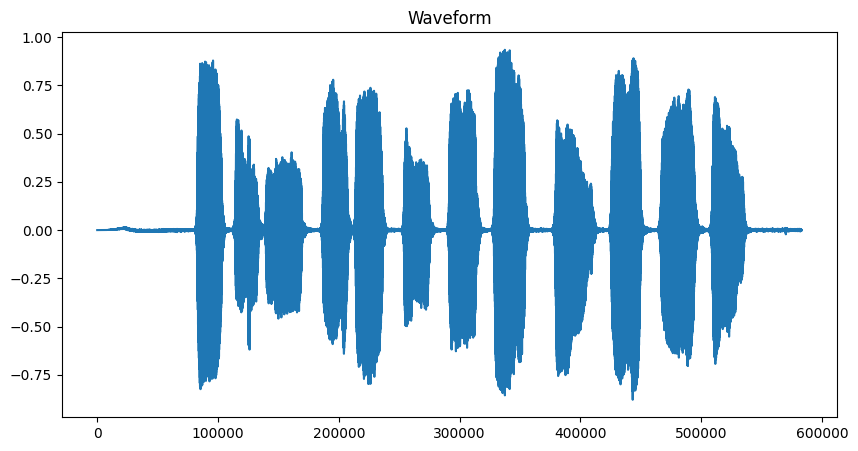

Notes in interval: 1
Notes in interval: 1
Notes in interval: 2
Notes in interval: 1
Notes in interval: 1
Notes in interval: 1
Notes in interval: 1
Notes in interval: 2
Notes in interval: 2
Notes in interval: 1
Notes in interval: 2
Notes in interval: 2
Extracted data shape: (17, 128, 29)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
Predicted Classes: [0 6 6 6 0 4 6 0 0 0 4 4 0 4 0 4 4]


In [54]:
import numpy as np
import os

# Define file path
file_path = "/content/drive/My Drive/hackathon_projects/flute_guide/flute_teaching_kit/model/test_1.wav"

# Check if file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

# Extract features
data = data_extraction(file_path)

# Convert extracted data into NumPy array
X_test = np.array(data)

# Check extracted data shape
print("Extracted data shape:", X_test.shape)  # Debugging

# Reshape to match model input (batch, height, width, channels)
if X_test.shape[0] > 0:  # Ensure valid data exists
    X_test = X_test.reshape(X_test.shape[0], 128, X_test.shape[2], 1)  # Adjust width dynamically
else:
    raise ValueError("No valid features extracted!")

# Ensure model file exists before loading
model_path = "/content/drive/My Drive/hackathon_projects/flute_guide/flute_teaching_kit/model/crnn_model_final.keras"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found: {model_path}")

# Load Model
import tensorflow as tf
model = tf.keras.models.load_model(model_path)

# Make predictions
predictions = model.predict(X_test)

# Get predicted class
predicted_classes = np.argmax(predictions, axis=1)
print("Predicted Classes:", predicted_classes)